# Machine Learning Skill Assessment

### by Hector Kroes

In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import numpy as np
import graphviz
import warnings
import re
import os

To begin with, we need to import the training data. We will use this data to train our model and generate predictions on the test file, the results of which will be submitted to Kaggle. Below is the unaltered dataframe and a general exploration of the variables available in it:

In [2]:
titanic_df = pd.read_csv('train.csv')
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


As seen in the dataframe variable info, there are 177 null values in the age column. To avoid discarding a significant part of our data, we can implement an age imputer that will fill these null values with the mean age value of the sample. We can create categorical variables to expand our inference capabilities. Additionally, we can encode multi-value variables into binary classifications to facilitate the inclusion of these elements in our model. And at last, we can drop variables which we will not use in the model. This is all integrated in a pipeline so the format becomes easily applicable both in the training and the test set.

In [6]:
class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None) :
        return self

    def transform (self, X):
        
        X['Fare'] = X['Fare'].fillna(method='ffill')
        
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

In [7]:
class CategoricalFeatures(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None) :
        return self
    
    def transform(self, X):
        
        def create_feat_categoricalFare(df, colname):
            return pd.qcut(df[colname], 4, labels = [0, 1, 2, 3]).astype(int)
        
        X['CategoricalFare'] = create_feat_categoricalFare(X, 'Fare')
        
        Title_Dictionary = {
        "Capt":       "Officer",
        "Col":        "Officer",
        "Major":      "Officer",
        "Dr":         "Officer",
        "Rev":        "Officer",
        "Jonkheer":   "Royalty",
        "Don":        "Royalty",
        "Sir" :       "Royalty",
        "Countess":"Royalty",
        "Dona":       "Royalty",
        "Lady" :      "Royalty",
        "Mme":        "Mrs",
        "Ms":         "Mrs",
        "Mrs" :       "Mrs",
        "Mlle":       "Miss",
        "Miss" :      "Miss",
        "Mr" :        "Mr",
        "Master" :    "Master"}
        
        X['Title'] = X.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
        X['Title'] = X.Title.map(Title_Dictionary)
        
        return X

In [8]:
class FeatureEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None) :
        return self

    def transform(self, X):

        encoder = OneHotEncoder()
        
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        column_names = ["Embark_C", "Embark_S", "Embark_Q", "Embark_N"]
        if len(matrix.T) < 4:
            tmatrix = np.vstack([matrix.T, np.array([0 for i in range(len(matrix))])])
        else:
            tmatrix = matrix.T
        for i in range(len(tmatrix)):
            X[column_names[i]] = tmatrix[i]
            
        matrix = encoder.fit_transform(X[['Title']]).toarray()
        column_names = ['Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty']
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
        matrix = encoder.fit_transform(X[['CategoricalFare']]).toarray()
        column_names = ["Fare_Cat_1", "Fare_Cat_2", "Fare_Cat_3", "Fare_Cat_4"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
        X['Sex'] = X['Sex'].replace(['female','male'],[0,1])
            
        return X

In [9]:
class FeatureDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None) :
        return self
    
    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "N", "Title", "CategoricalFare"], axis=1, errors="ignore")

In [10]:
prep_pipeline = Pipeline([("age_imputer", AgeImputer()),
    ("categorizer", CategoricalFeatures()),
    ("feature_encoder",FeatureEncoder()),
    ("feature_dropper",FeatureDropper())])

In [11]:
manipulated_data = prep_pipeline.fit_transform(titanic_df)

So now the manipulated dataframe, as shown below, has better formatted information and no null values:

In [12]:
manipulated_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embark_C,Embark_S,...,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Fare_Cat_1,Fare_Cat_2,Fare_Cat_3,Fare_Cat_4
0,1,0,3,1,22.000000,1,0,7.2500,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,1,1,0,38.000000,1,0,71.2833,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,1,3,0,26.000000,0,0,7.9250,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,1,1,0,35.000000,1,0,53.1000,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,0,3,1,35.000000,0,0,8.0500,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.000000,0,0,13.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
887,888,1,1,0,19.000000,0,0,30.0000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
888,889,0,3,0,29.699118,1,2,23.4500,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
889,890,1,1,1,26.000000,0,0,30.0000,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
manipulated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Sex            891 non-null    int64  
 4   Age            891 non-null    float64
 5   SibSp          891 non-null    int64  
 6   Parch          891 non-null    int64  
 7   Fare           891 non-null    float64
 8   Embark_C       891 non-null    float64
 9   Embark_S       891 non-null    float64
 10  Embark_Q       891 non-null    float64
 11  Embark_N       891 non-null    float64
 12  Title_Master   891 non-null    float64
 13  Title_Miss     891 non-null    float64
 14  Title_Mr       891 non-null    float64
 15  Title_Mrs      891 non-null    float64
 16  Title_Officer  891 non-null    float64
 17  Title_Royalty  891 non-null    float64
 18  Fare_Cat_1

In [14]:
manipulated_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embark_C         0
Embark_S         0
Embark_Q         0
Embark_N         0
Title_Master     0
Title_Miss       0
Title_Mr         0
Title_Mrs        0
Title_Officer    0
Title_Royalty    0
Fare_Cat_1       0
Fare_Cat_2       0
Fare_Cat_3       0
Fare_Cat_4       0
dtype: int64

In [15]:
manipulated_data.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embark_C,Embark_S,...,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Fare_Cat_1,Fare_Cat_2,Fare_Cat_3,Fare_Cat_4
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,0.188552,0.086420,...,0.044893,0.206510,0.580247,0.142536,0.020202,0.005612,0.250281,0.251403,0.249158,0.249158
std,257.353842,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.693429,0.391372,0.281141,...,0.207186,0.405028,0.493796,0.349796,0.140770,0.074743,0.433418,0.434063,0.432769,0.432769
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,1.000000,29.699118,0.000000,0.000000,14.454200,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.500000,1.000000,0.000000,0.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can analyse the correlations between variables and the potential usefulness of those variables for the prediction of our outcome through plots such as the correlation heatmap and PCA shown below:

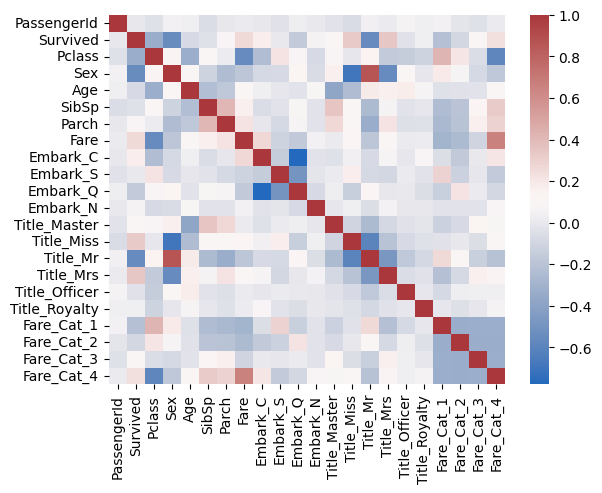

In [16]:
sns.heatmap(manipulated_data.corr(), cmap=sns.color_palette("vlag", as_cmap=True))
warnings.simplefilter(action='ignore', category=FutureWarning)

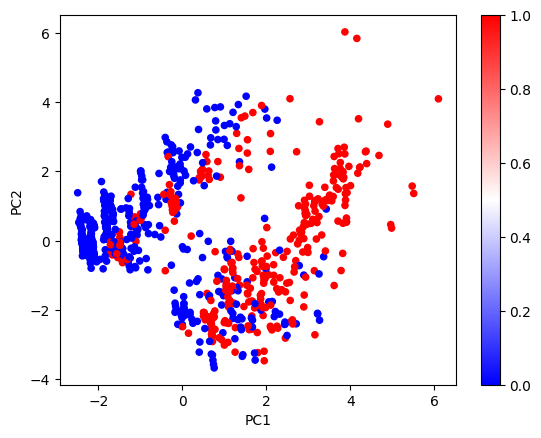

In [17]:
pca_model = PCA(n_components=2)

pca_feat = StandardScaler().fit_transform(manipulated_data)
pc_data = pca_model.fit_transform(pca_feat)

transformed = pd.DataFrame(data = pc_data, columns = ['PC1', 'PC2'])
plot = transformed.plot.scatter(x ='PC1', y='PC2',c=manipulated_data["Survived"],colormap='bwr')

And as we start implementing our program, we need to separate the survival field from the rest of the variables and turn the pandas dataframes into numpy arrays. In this way we can use the variables array as input variables to the model and the survival information as annotation that will be used as reference for the predictions.

In [18]:
scaler = StandardScaler()

data = manipulated_data.drop(['Survived'], axis=1)
results = manipulated_data['Survived']

data_nparray = scaler.fit_transform(data)
results_nparray = results.to_numpy()

Then, we are able to build our model. We will use a random forest classifier for this task. It builds decision trees and uses them to generate the predictions from a serial comparison of values. The general structure of this model is shown below, where we plot the head of a single one of its branches.

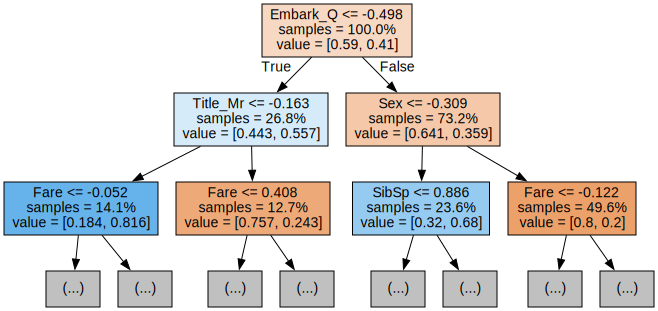

In [19]:
rfc_model = RandomForestClassifier()

rfc_model.fit(data_nparray, results_nparray)

os.environ["PATH"] += os.pathsep +'C:/Program Files/Graphviz/bin/'

tree = rfc_model.estimators_[0]
dot_data = export_graphviz(tree,
        feature_names=data.columns,  
        filled=True,
        max_depth=2, 
        impurity=False, 
        proportion=True)

graph = graphviz.Source(dot_data)
display(graph)

We now use the function GridSearchCV to determine optimal parameters for the model, which we will use to predict the outcomes of the test dataset.

In [20]:
param_grid = [{"n_estimators": [1, 10, 100, 200, 500, 1000], "max_depth": [None, 1, 5, 10, 20, 40], "min_samples_split": [2,3,4,5,6,8,10]}]
tuned_rfc= GridSearchCV(rfc_model, param_grid, cv=3, scoring="accuracy", return_train_score=True)
tuned_rfc.fit(data_nparray, results_nparray)
tuned_rfc

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 1, 5, 10, 20, 40],
                          'min_samples_split': [2, 3, 4, 5, 6, 8, 10],
                          'n_estimators': [1, 10, 100, 200, 500, 1000]}],
             return_train_score=True, scoring='accuracy')

In [21]:
clf_params = tuned_rfc.best_estimator_
clf_params

RandomForestClassifier(n_estimators=10)

And lastly, we can apply the model to the test dataframe, generating predictions that will be saved in a csv file:

In [22]:
test_data = pd.read_csv("test.csv")

formatted_test_data = prep_pipeline.fit_transform(test_data)

formatted_test_data.info()

formatted_test_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    418 non-null    int64  
 1   Pclass         418 non-null    int64  
 2   Sex            418 non-null    int64  
 3   Age            418 non-null    float64
 4   SibSp          418 non-null    int64  
 5   Parch          418 non-null    int64  
 6   Fare           418 non-null    float64
 7   Embark_C       418 non-null    float64
 8   Embark_S       418 non-null    float64
 9   Embark_Q       418 non-null    float64
 10  Embark_N       418 non-null    float64
 11  Title_Master   418 non-null    float64
 12  Title_Miss     418 non-null    float64
 13  Title_Mr       418 non-null    float64
 14  Title_Mrs      418 non-null    float64
 15  Title_Officer  418 non-null    float64
 16  Title_Royalty  418 non-null    float64
 17  Fare_Cat_1     418 non-null    float64
 18  Fare_Cat_2

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embark_C,Embark_S,Embark_Q,...,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Fare_Cat_1,Fare_Cat_2,Fare_Cat_3,Fare_Cat_4
0,892,3,1,34.50000,0,0,7.8292,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,893,3,0,47.00000,1,0,7.0000,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,894,2,1,62.00000,0,0,9.6875,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,895,3,1,27.00000,0,0,8.6625,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,896,3,0,22.00000,1,1,12.2875,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,1,30.27259,0,0,8.0500,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
414,1306,1,0,39.00000,0,0,108.9000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
415,1307,3,1,38.50000,0,0,7.2500,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
416,1308,3,1,30.27259,0,0,8.0500,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [23]:
model_input = scaler.fit_transform(formatted_test_data)

predictions = clf_params.predict(model_input)

predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [24]:
predictions_df = pd.DataFrame(test_data['PassengerId'])
predictions_df['Survived'] = predictions
predictions_df.to_csv('predictions.csv', index=False)
predictions_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
